<a href="https://colab.research.google.com/github/costpetrides/FAIRMODE-WG5/blob/main/Python/XGBSF_PM25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install xgboost

In [2]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 64.4 MB/s eta 0:00:00


In [3]:
pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import netCDF4 as nc
import xgboost as xgb
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import BallTree
from tqdm import tqdm

# === Load CSV Data (Station Measurements) ===
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Compute Bias (Observed - Modeled)
df["bias"] = df["SURF_ug_PM25_rh50"] - df["nearest_SURF_ug_PM25_rh50"]

# === Load NetCDF Data (Grid Model) ===
netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
pm25_modeled = dataset.variables["SURF_ug_PM25_rh50"][0, :, :]

# Convert Degrees to Radians for Haversine Distance
lon_rad = np.radians(lon)
lat_rad = np.radians(lat)

# === Create Meshgrid for Grid Points ===
lon_mesh, lat_mesh = np.meshgrid(lon_rad, lat_rad)
grid_points = np.column_stack([lat_mesh.ravel(), lon_mesh.ravel()])

# === Prepare Station Data (Convert to Radians) ===
station_points = np.column_stack([
    np.radians(df["nearest_grid_lat"].values),
    np.radians(df["nearest_grid_lon"].values)
])
station_pm25 = df["nearest_SURF_ug_PM25_rh50"].values  # Modeled PM₂.₅ at stations
station_bias = df["bias"].values  # Observed bias

# === BallTree for Nearest Neighbor Search ===
tree = BallTree(station_points, metric="haversine")

# === Function: Compute Spatial Features ===
def compute_spatial_features(points, station_points, station_pm25, station_bias, k=5):
    """Finds nearest k stations and computes mean, min, max, variance, and IDW-weighted PM₂.₅."""
    dists, idxs = tree.query(points, k=k)

    mean_pm25 = np.mean(station_pm25[idxs], axis=1)
    min_pm25 = np.min(station_pm25[idxs], axis=1)
    max_pm25 = np.max(station_pm25[idxs], axis=1)
    var_pm25 = np.var(station_pm25[idxs], axis=1)  # Variance of nearest PM₂.₅ values
    mean_bias = np.mean(station_bias[idxs], axis=1)  # Mean Bias of nearest neighbors

    weights = 1 / (dists + 1e-6)  # Avoid division by zero
    weights /= np.sum(weights, axis=1, keepdims=True)

    idw_pm25 = np.sum(weights * station_pm25[idxs], axis=1)

    return mean_pm25, min_pm25, max_pm25, var_pm25, idw_pm25, mean_bias

# === Compute Spatial Features for Stations ===
mean_pm25_s, min_pm25_s, max_pm25_s, var_pm25_s, idw_pm25_s, mean_bias_s = compute_spatial_features(
    station_points, station_points, station_pm25, station_bias, k=5
)

# Construct Feature Matrix for XGBoost Training
X_train = np.column_stack([
    df["nearest_grid_lon"].values,
    df["nearest_grid_lat"].values,
    df["nearest_SURF_ug_PM25_rh50"].values,
    mean_pm25_s, min_pm25_s, max_pm25_s, var_pm25_s, idw_pm25_s, mean_bias_s
])
y_train = station_bias  # Target: Bias

# === Compute Spatial Features for Grid Points ===
mean_pm25_g, min_pm25_g, max_pm25_g, var_pm25_g, idw_pm25_g, mean_bias_g = compute_spatial_features(
    grid_points, station_points, station_pm25, station_bias, k=5
)

# Construct Feature Matrix for XGBoost Prediction
X_grid = np.column_stack([
    np.degrees(grid_points[:, 1]),  # Convert back to degrees
    np.degrees(grid_points[:, 0]),
    pm25_modeled.ravel(),
    mean_pm25_g, min_pm25_g, max_pm25_g, var_pm25_g, idw_pm25_g, mean_bias_g
])

# === Hyperparameter Grid for XGBoost ===
param_grid = {
    "n_estimators": [100, 300],
    "max_depth": [10, 15],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.1, 0.2],
}

param_list = list(ParameterGrid(param_grid))

# === Grid Search with RMSE, MAE, R² Calculation ===
best_rmse = float("inf")
best_params = None
results = []

print("\nPerforming Hyperparameter Optimization (XGBoost)...")

for params in tqdm(param_list, desc="Grid Search Progress", unit="combination"):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    fold_rmses, fold_maes, fold_r2s = [], [], []

    for train_idx, test_idx in kf.split(X_train):
        X_tr, X_te = X_train[train_idx], X_train[test_idx]
        y_tr, y_te = y_train[train_idx], y_train[test_idx]

        model = xgb.XGBRegressor(**params, random_state=42, n_jobs=-1)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)

        fold_rmse = np.sqrt(mean_squared_error(y_te, y_pred))
        fold_mae = mean_absolute_error(y_te, y_pred)
        fold_r2 = r2_score(y_te, y_pred)

        fold_rmses.append(fold_rmse)
        fold_maes.append(fold_mae)
        fold_r2s.append(fold_r2)

    mean_rmse = np.mean(fold_rmses)
    mean_mae = np.mean(fold_maes)
    mean_r2 = np.mean(fold_r2s)

    results.append((params, mean_rmse, mean_mae, mean_r2))

    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_params = params

print(f"\n✅ Best Parameters Found: {best_params} with RMSE: {best_rmse:.4f}")

# Save results
results_df = pd.DataFrame(results, columns=["params", "RMSE", "MAE", "R2"])
results_df.to_csv("BaseCase_PM25_rh50_Y_XGB_Val.csv", index=False)

# Train Final XGBoost Model with Best Parameters
best_model = xgb.XGBRegressor(**best_params, random_state=42, n_jobs=-1)
best_model.fit(X_train, y_train)

# === Predict Bias on the Grid ===
print("\n🚀 Predicting Bias on the Grid with Optimized XGBoost...")
interpolated_bias_xgb = best_model.predict(X_grid)
interpolated_bias_xgb = interpolated_bias_xgb.reshape(pm25_modeled.shape)

# === Save Bias Correction to NetCDF ===
xgb_bias_netcdf_path = "BaseCase_PM25_rh50_Y_XGB.nc"

with nc.Dataset(xgb_bias_netcdf_path, "w", format="NETCDF4") as bias_nc:
    bias_nc.createDimension("lat", lat.shape[0])
    bias_nc.createDimension("lon", lon.shape[0])

    lat_var = bias_nc.createVariable("lat", "f4", ("lat",))
    lon_var = bias_nc.createVariable("lon", "f4", ("lon",))
    bias_var = bias_nc.createVariable("Interpolated_Bias_XGB", "f4", ("lat", "lon"))

    bias_var.setncatts(dataset.variables["SURF_ug_PM25_rh50"].__dict__)
    bias_nc.description = "Bias Interpolated using Optimized XGBoost with Spatial & Neighbor Features"

    lat_var[:] = lat
    lon_var[:] = lon
    bias_var[:, :] = interpolated_bias_xgb

print(f"\n✅ XGBoost Bias Interpolation Saved: {xgb_bias_netcdf_path}")

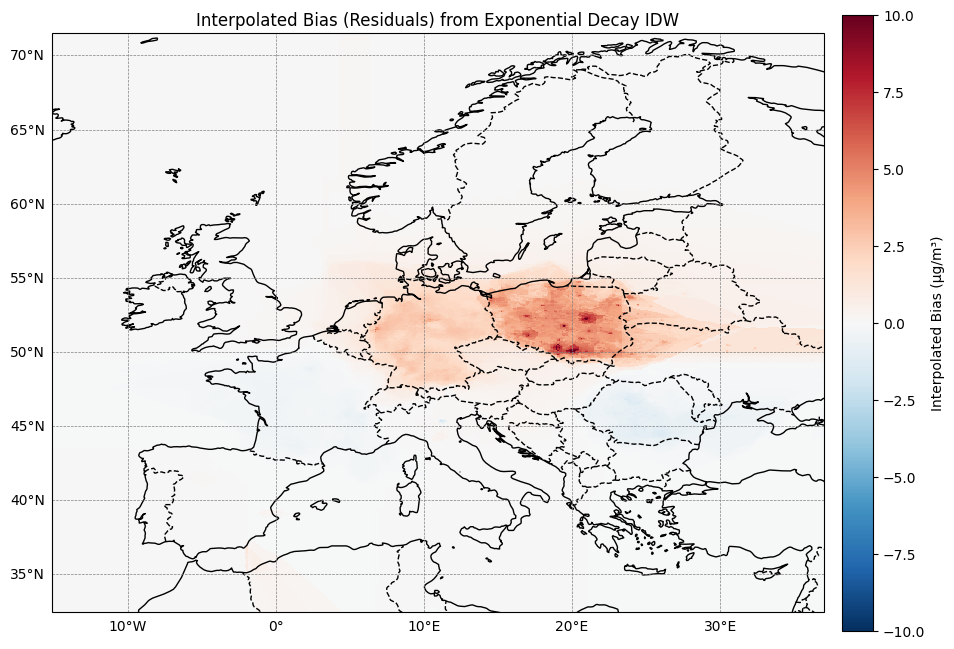

In [8]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Interpolated Bias NetCDF File ===
bias_netcdf_path = "BaseCase_PM25_rh50_Y_XGB.nc"
ds_bias = xr.open_dataset(bias_netcdf_path)

# Extract interpolated bias (residuals)
interpolated_bias = ds_bias["Interpolated_Bias_XGB"].squeeze().values

# Extract coordinates
lon = ds_bias["lon"].values
lat = ds_bias["lat"].values

# === Define Plot Limits (Adjust if needed) ===
cbar_min = -10  # Minimum bias value for color scale
cbar_max = 10  # Maximum bias value for color scale

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the interpolated bias
im = ax.pcolormesh(lon, lat, interpolated_bias, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("Interpolated Bias (µg/m³)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Interpolated Bias (Residuals) from Exponential Decay IDW")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close dataset
ds_bias.close()
